In [1]:
import torch

# ✅ Setup device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cuda


In [3]:
# ✅ Setup device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [4]:
import os
import torch
import torchvision.transforms as transforms
from torchvision.models import mobilenet_v2
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import numpy as np
import pandas as pd
from tqdm import tqdm

In [5]:

# --------------------------------
# Step 1: Setup GPU (CUDA) Device
# --------------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"🔍 Using device: {device}")
if device.type == 'cuda':
    print(f"🧠 CUDA Device Name: {torch.cuda.get_device_name(0)}")
    print(f"🔋 Memory Allocated: {round(torch.cuda.memory_allocated(0)/1024**3, 2)} GB")


🔍 Using device: cuda
🧠 CUDA Device Name: NVIDIA GeForce RTX 3060
🔋 Memory Allocated: 0.0 GB


In [6]:

# -------------------------------
# Step 2: Paths to image folders
# -------------------------------
train_dir = "C:\\yolo realcolon work\\feature_extraction\\dataset_for_feature_extraction\\train_polyp"
val_dir   = "C:\\yolo realcolon work\\feature_extraction\\dataset_for_feature_extraction\\val_polyp"



In [7]:


# -------------------------------
# Step 3: Define preprocessing
# -------------------------------
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std =[0.229, 0.224, 0.225])
])


In [8]:
from torchvision.datasets import ImageFolder

dataset = ImageFolder(root=r"C:\yolo realcolon work\feature_extraction\dataset_for_feature_extraction\train_polyp")
print("Classes:", dataset.classes)


Classes: ['polyp']


In [9]:

# -------------------------------
# Step 4: Load datasets
# -------------------------------
train_dataset = ImageFolder(root=train_dir, transform=transform)
val_dataset = ImageFolder(root=val_dir, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)



In [10]:



# -------------------------------
# Step 5: Load MobileNetV2 model
# -------------------------------
model = mobilenet_v2(pretrained=True)
model.classifier = torch.nn.Identity()  # Remove classification head
model.to(device)
model.eval()


c:\Users\ADMIN\anaconda3\envs\akash\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\ADMIN\anaconda3\envs\akash\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

In [11]:

# -------------------------------
# Step 6: Feature extraction function
# -------------------------------
def extract_features(dataloader, dataset, dataset_type="train"):
    all_features = []
    all_filenames = []

    with torch.no_grad():
        for images, _ in tqdm(dataloader, desc=f"Extracting {dataset_type} features"):
            images = images.to(device)
            features = model(images)
            all_features.append(features.cpu().numpy())

        # Get the corresponding file paths (in same order as dataloader)
        for path, _ in dataset.samples:
            all_filenames.append(os.path.basename(path))  # just filename

    all_features = np.vstack(all_features)
    return all_features, all_filenames


In [12]:

# -------------------------------
# Step 7: Extract features
# -------------------------------
train_features, train_filenames = extract_features(train_loader, train_dataset, "train")
val_features, val_filenames = extract_features(val_loader, val_dataset, "val")


Extracting val features: 100%|██████████| 112/112 [00:09<00:00, 11.83it/s]


In [13]:

# -------------------------------
# Step 8: Save features to disk
# -------------------------------
np.save("mobilenet_train_features.npy", train_features)
np.save("mobilenet_val_features.npy", val_features)

# Optionally, save to CSV with filenames
pd.DataFrame(train_features, index=train_filenames).to_csv("mobilenet_train_features.csv")
pd.DataFrame(val_features, index=val_filenames).to_csv("mobilenet_val_features.csv")

print("✅ Feature extraction complete. Files saved.")


✅ Feature extraction complete. Files saved.


# clustering without ensemble


In [1]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering, SpectralClustering
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:

import pandas as pd

# Step 1: Load correctly with header
df = pd.read_csv("C:\other experiment\mobilenet_train_features.csv")  # Header assumed if filenames present

# ✅ Remove non-numeric columns like 'filename'
numeric_df = df.select_dtypes(include=[np.number])  # Automatically removes filename
mobilenet_features = numeric_df.values  # clean numeric array for UMAP

from sklearn.feature_selection import VarianceThreshold
selector = VarianceThreshold(threshold=0.01)
mobilenet_reduced = selector.fit_transform(mobilenet_features)


def evaluate(name, features, labels):
    print(f"\n📊 {name} Evaluation:")
    if len(set(labels)) > 1 and -1 not in set(labels):
        print(f"Silhouette Score: {silhouette_score(features, labels):.4f}")
        print(f"Davies-Bouldin Index: {davies_bouldin_score(features, labels):.4f}")
        print(f"Calinski-Harabasz Index: {calinski_harabasz_score(features, labels):.4f}")
    else:
        print("❌ Not enough valid clusters for evaluation.")



import umap

umap_model = umap.UMAP(
    n_neighbors=10,          # try 5, 10, 15, 30
    min_dist=0.05,          # lower → tighter clusters
    # n_components=10,        # use more dimensions for better cluster separation
    metric="cosine",        # cosine distance works well with image features
    random_state=42
)
umap_features = umap_model.fit_transform(mobilenet_reduced)


# ---------------------------
# Step 3: Normalize
# ---------------------------
scaler = StandardScaler()
scaled_features = scaler.fit_transform(umap_features)

kmeans_labels = KMeans(n_clusters=2, random_state=42).fit_predict(scaled_features)
evaluate("KMeans", scaled_features, kmeans_labels)


# ✅ Agglomerative (Euclidean)
agglo = AgglomerativeClustering(n_clusters=2, metric="euclidean", linkage="ward")  #metric="eucledian"/manhattan
agglo_labels_euclidean = agglo.fit_predict(scaled_features)

evaluate("Agglomerative (euclidean)", scaled_features, agglo_labels_euclidean)



<>:4: SyntaxWarning: invalid escape sequence '\o'
<>:4: SyntaxWarning: invalid escape sequence '\o'
C:\Users\ADMIN\AppData\Local\Temp\ipykernel_1976\3363830635.py:4: SyntaxWarning: invalid escape sequence '\o'
  df = pd.read_csv("C:\other experiment\mobilenet_train_features.csv")  # Header assumed if filenames present
c:\Users\ADMIN\anaconda3\envs\akash\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\ADMIN\anaconda3\envs\akash\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\ADMIN\anaconda3\envs\akash\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(



📊 KMeans Evaluation:
Silhouette Score: 0.4153
Davies-Bouldin Index: 0.9664
Calinski-Harabasz Index: 25525.4609

📊 Agglomerative (euclidean) Evaluation:
Silhouette Score: 0.3550
Davies-Bouldin Index: 1.0282
Calinski-Harabasz Index: 20705.5195


In [5]:
# ---------------------------
# Step 6: Save Results
# ---------------------------
df_result = pd.DataFrame(scaled_features)
df_result["kmeans_label"] = kmeans_labels
df_result["agglo_label"] = agglo_labels_euclidean
df_result.to_csv("mobilenet_features_umap_clustering.csv", index=False)


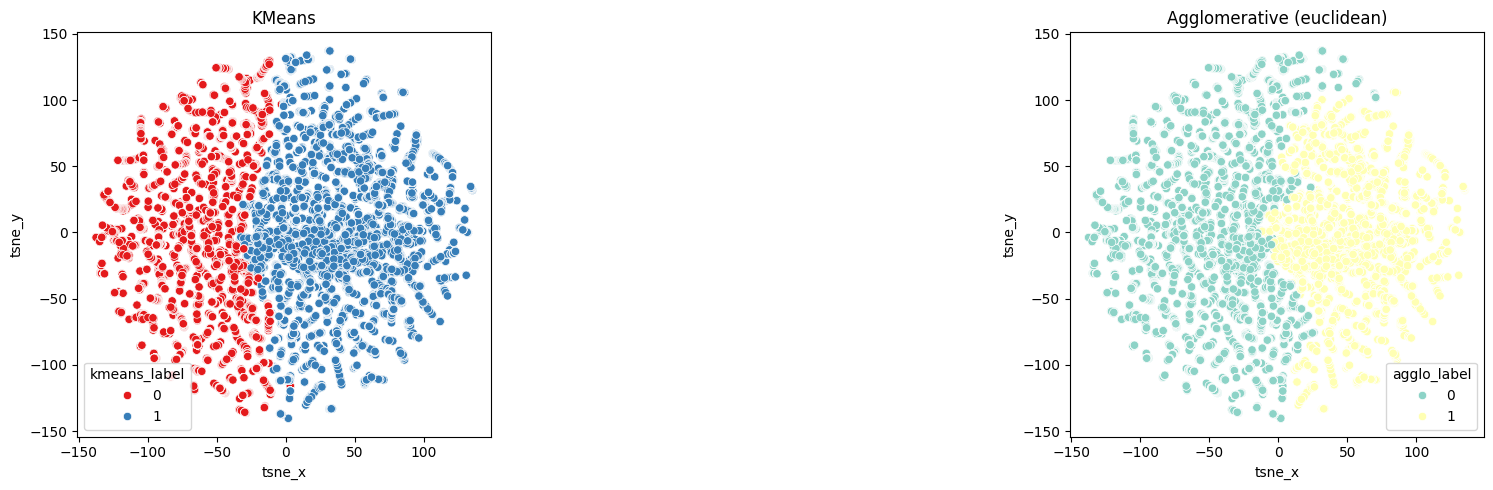

In [8]:

# ---------------------------
# Step 7: t-SNE Visualization
# ---------------------------
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
tsne_2d = tsne.fit_transform(scaled_features)
df_result["tsne_x"] = tsne_2d[:, 0]
df_result["tsne_y"] = tsne_2d[:, 1]

plt.figure(figsize=(20, 5))

plt.subplot(1, 4, 1)
sns.scatterplot(data=df_result, x="tsne_x", y="tsne_y", hue="kmeans_label", palette="Set1")
plt.title("KMeans")


plt.subplot(1, 4, 3)
sns.scatterplot(data=df_result, x="tsne_x", y="tsne_y", hue="agglo_label", palette="Set3")
plt.title("Agglomerative (euclidean)")

# plt.subplot(1, 4, 4)
# sns.scatterplot(data=df_result, x="tsne_x", y="tsne_y", hue="spectral_label", palette="coolwarm")
# plt.title("Spectral Clustering")

plt.tight_layout()
plt.show()


# ensemble clustering with 3 class

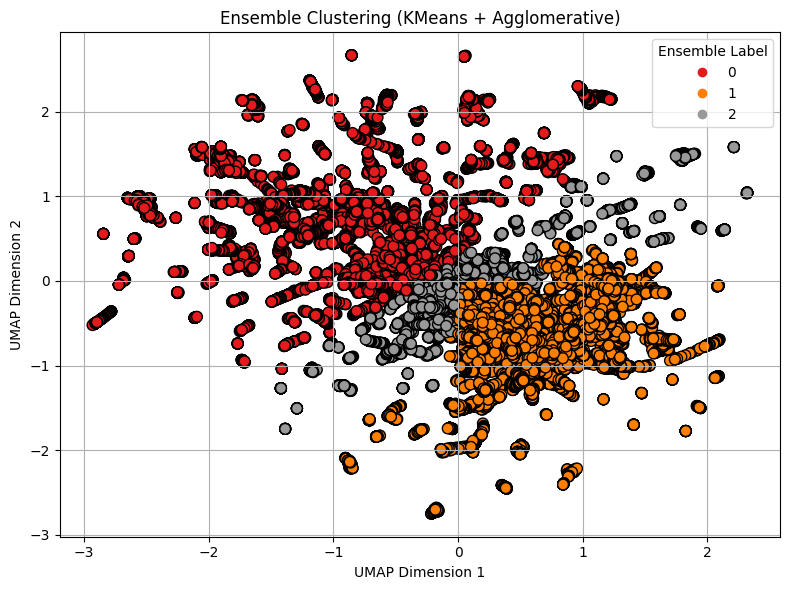

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load the CSV file with clustering results
df = pd.read_csv("mobilenet_features_umap_clustering.csv")

# Compute ensemble labels based on agreement between KMeans and Agglomerative
def compute_ensemble(k, a):
    if k == a:
        return k
    else:
        return 2

df["ensemble_label"] = df.apply(lambda row: compute_ensemble(row["kmeans_label"], row["agglo_label"]), axis=1)

# Save new CSV with ensemble labels
df.to_csv("mobilenet_features_umap_ensemble.csv", index=False)

# Plotting (assumes first two columns are 2D UMAP features)
plt.figure(figsize=(8, 6))
scatter = plt.scatter(
    df.iloc[:, 0], df.iloc[:, 1],
    c=df["ensemble_label"], cmap='Set1', edgecolor='k', s=60
)
plt.title("Ensemble Clustering (KMeans + Agglomerative)")
plt.xlabel("UMAP Dimension 1")
plt.ylabel("UMAP Dimension 2")
plt.legend(*scatter.legend_elements(), title="Ensemble Label")
plt.grid(True)
plt.tight_layout()
plt.show()


In [5]:
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
import pandas as pd

# Load your CSV with ensemble_label
df = pd.read_csv("mobilenet_features_umap_ensemble.csv")

# Use the 2D UMAP features (assumed to be first 2 columns)
X = df.iloc[:, 0:2].values
y = df["ensemble_label"].values

# Filter out points labeled as 2 (disagreement/mismatch) if you only want to evaluate clearly agreed clusters (0 and 1)
# Otherwise, keep as-is to evaluate all 3 clusters

if len(set(y)) > 1 and len(set(y)) <= len(X):  # Ensure at least 2 unique clusters
    sil_score = silhouette_score(X, y)
    dbi = davies_bouldin_score(X, y)
    chi = calinski_harabasz_score(X, y)

    print(f"📊 Ensemble Clustering Evaluation:")
    print(f"Silhouette Score: {sil_score:.4f}")
    print(f"Davies-Bouldin Index: {dbi:.4f}")
    print(f"Calinski-Harabasz Index: {chi:.4f}")
else:
    print("❌ Not enough valid clusters to evaluate.")


📊 Ensemble Clustering Evaluation:
Silhouette Score: 0.2332
Davies-Bouldin Index: 1.6604
Calinski-Harabasz Index: 15439.7635


# neglecting label=2 from ensemble clustering

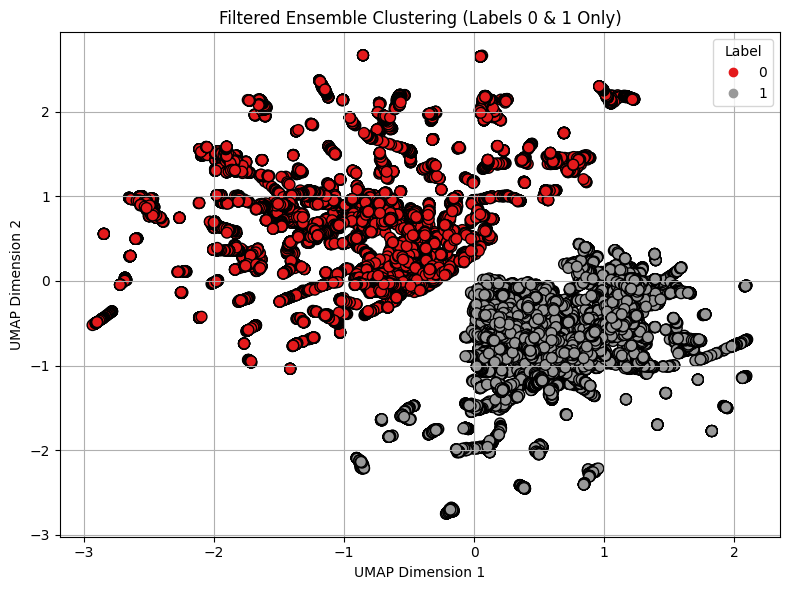


📊 Evaluation Metrics (Labels 0 & 1 Only):
Silhouette Score: 0.4942
Davies-Bouldin Index: 0.8017
Calinski-Harabasz Index: 31277.5198


In [6]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

# Load ensemble clustering data
df = pd.read_csv("mobilenet_features_umap_ensemble.csv")

# Filter to keep only labels 0 and 1
filtered_df = df[df["ensemble_label"] != 2].copy()

# Extract UMAP features (assumed in first 2 columns)
X = filtered_df.iloc[:, 0:2].values
labels = filtered_df["ensemble_label"].values

# Plot the filtered ensemble clustering
plt.figure(figsize=(8, 6))
scatter = plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='Set1', edgecolor='k', s=60)
plt.title("Filtered Ensemble Clustering (Labels 0 & 1 Only)")
plt.xlabel("UMAP Dimension 1")
plt.ylabel("UMAP Dimension 2")
plt.legend(*scatter.legend_elements(), title="Label")
plt.grid(True)
plt.tight_layout()
plt.show()

# Evaluation Scores
print("\n📊 Evaluation Metrics (Labels 0 & 1 Only):")
print(f"Silhouette Score: {silhouette_score(X, labels):.4f}")
print(f"Davies-Bouldin Index: {davies_bouldin_score(X, labels):.4f}")
print(f"Calinski-Harabasz Index: {calinski_harabasz_score(X, labels):.4f}")


In [11]:
import pandas as pd
import numpy as np
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
import umap

# -------------------------
# STEP 1: Load Validation Features
# -------------------------
val_df = pd.read_csv("C:\other experiment\mobilenet_val_features.csv")
val_numeric = val_df.select_dtypes(include=[np.number])

# -------------------------
# STEP 2: Apply Same Variance Threshold
# -------------------------
# Note: Use the same threshold (0.01), but fit again if not saved
selector = VarianceThreshold(threshold=0.01)
val_reduced = selector.fit_transform(val_numeric)

# -------------------------
# STEP 3: Apply Same UMAP Settings
# -------------------------
umap_model = umap.UMAP(
    n_neighbors=10,
    min_dist=0.05,
    metric="cosine",
    random_state=42
)
val_umap = umap_model.fit_transform(val_reduced)

# -------------------------
# STEP 4: Normalize
# -------------------------
scaler = StandardScaler()
val_scaled = scaler.fit_transform(val_umap)

# -------------------------
# STEP 5: Clustering
# -------------------------
kmeans_labels = KMeans(n_clusters=2, random_state=42).fit_predict(val_scaled)
agglo_labels = AgglomerativeClustering(n_clusters=2, metric="euclidean", linkage="ward").fit_predict(val_scaled)

# -------------------------
# STEP 6: Ensemble Clustering
# -------------------------
def ensemble_label(k, a):
    if k == a:
        return k
    else:
        return 2  # disagreement

ensemble_labels = [ensemble_label(k, a) for k, a in zip(kmeans_labels, agglo_labels)]

# Save if needed
df_result = pd.DataFrame(val_scaled, columns=["UMAP1", "UMAP2"])
df_result["kmeans"] = kmeans_labels
df_result["agglo"] = agglo_labels
df_result["ensemble"] = ensemble_labels
df_result.to_csv("mobilenet_val_clustering_results.csv", index=False)

# -------------------------
# STEP 7: Evaluate Ensemble Labels (excluding label 2)
# -------------------------
filtered_df = df_result[df_result["ensemble"] != 2]
X = filtered_df[["UMAP1", "UMAP2"]].values
y = filtered_df["ensemble"].values

print("\n📊 Validation Results (Ensemble Agreement Only):")
print(f"Silhouette Score: {silhouette_score(X, y):.4f}")
print(f"Davies-Bouldin Index: {davies_bouldin_score(X, y):.4f}")
print(f"Calinski-Harabasz Index: {calinski_harabasz_score(X, y):.4f}")


<>:12: SyntaxWarning: invalid escape sequence '\o'
<>:12: SyntaxWarning: invalid escape sequence '\o'
C:\Users\ADMIN\AppData\Local\Temp\ipykernel_1976\395784160.py:12: SyntaxWarning: invalid escape sequence '\o'
  val_df = pd.read_csv("C:\other experiment\mobilenet_val_features.csv")
c:\Users\ADMIN\anaconda3\envs\akash\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\ADMIN\anaconda3\envs\akash\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(



📊 Validation Results (Ensemble Agreement Only):
Silhouette Score: 0.5102
Davies-Bouldin Index: 0.6288
Calinski-Harabasz Index: 1950.9301


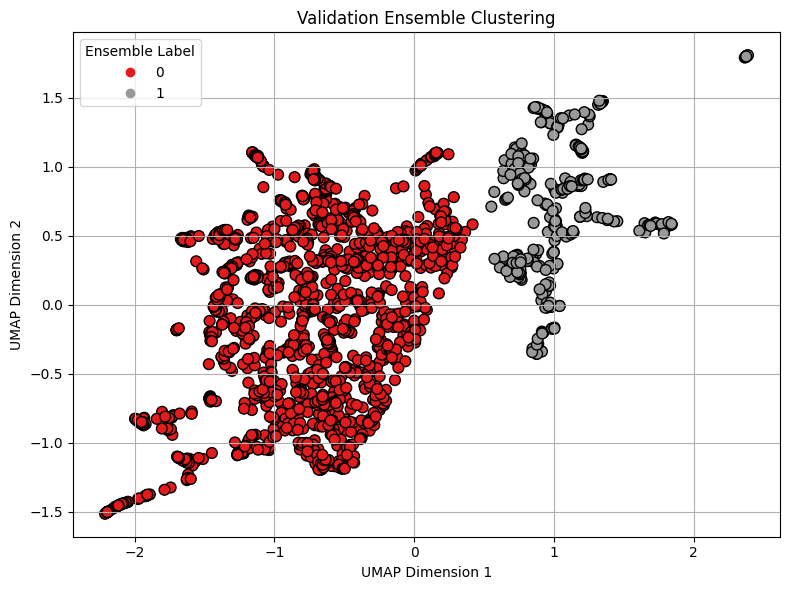

In [13]:
import matplotlib.pyplot as plt

# Plot the filtered ensemble clustering
plt.figure(figsize=(8, 6))
scatter = plt.scatter(
    filtered_df["UMAP1"],
    filtered_df["UMAP2"],
    c=filtered_df["ensemble"],
    cmap="Set1", edgecolor="k", s=60
)
plt.title("Validation Ensemble Clustering")
plt.xlabel("UMAP Dimension 1")
plt.ylabel("UMAP Dimension 2")
plt.legend(*scatter.legend_elements(), title="Ensemble Label")
plt.grid(True)
plt.tight_layout()
plt.show()
